## Word2Vec Approach

In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, \
    nltk, collections, keras, lightgbm as lgb
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import re,string,unicodedata
from string import punctuation
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from keras import layers
import keras_tuner

from keras.layers import Bidirectional, LSTM, GRU
import gensim


ModuleNotFoundError: No module named 'tensorflow'

## Preprocessing

In [7]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#article URLs not needed
df.drop(columns=['article_link'], inplace=True)

#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

NameError: name 'stopwords' is not defined

In [8]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing numbers as it can cause additional noise
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

#Removing the noisy text 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

C:\Users\denni\AppData\Local\Temp\ipykernel_6680\485613776.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

## Word2Vec Model

In [ ]:
#get w2v_model vocabulary size
w2v_model.wv.vectors.shape


(37056, 100)

In [ ]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
#tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#help from CHTGPT
padded_sequences = pad_sequences(sequences, maxlen=20)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
padded_sequences

array([[    0,     0,     0, ...,  2318,   555,   934],
       [    0,     0,     0, ..., 11257,  1977,  1796],
       [    0,     0,     0, ..., 16465,   475,  1346],
       ...,
       [    0,     0,     0, ...,   946,   665,  1639],
       [    0,     0,     0, ...,  2978,   815,  5899],
       [    0,     0,     0, ...,  2947,   171,    89]])

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

### Training Word2Vec model

In [ ]:
#tuner model for optimal hyperparameters



def build_model(hp):

    model = keras.Sequential()

    model.add(layers.Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=20, trainable=True))

    #tune the number of layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            Bidirectional(LSTM(
                #tune number of nodes separately
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                #tune recurrent dropout
                recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                #tune dropout
                dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                return_sequences=True,
                name=f"bidirectional_LSTM_{i}"
                )
            )
        )
        model.add(
            Bidirectional(GRU(
                #tune number of nodes separately
                units=hp.Int(f"units_{i}", min_value=8, max_value=512, step=32),
                #tune recurrent dropout
                recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                #tune dropout
                dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                name=f"bidirectional_GRU_{i}"
                )
            )
        )
        #tune learning rate
        learning_rate_tuned = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    #last Layer, use sigmoid activation function
    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    #compile the model, use binary_crossentropy loss function as we have a binary classification problem
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuned),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    #The total number of trials to run during the search.
    max_trials=3,
    #The number of models that should be built and fit for each trial.
    #The purpose of having multiple executions per trial is to reduce results variance and
    #therefore be able to more accurately assess the performance of a model
    executions_per_trial=2,
    overwrite=True,
    directory="tuner_sarcasm_detection",
    project_name="Sarcasm_Detection",
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
recurrent_dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.3 , random_state = 187) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3 , random_state = 187)

In [ ]:
#needs to be run on HPC
tuner.search(x_train, y_train, epochs=4, validation_data=(x_val, y_val))


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
384               |96                |units_0
0.4               |0                 |recurrent_dropout_0
0.2               |0.2               |dropout_0
0.00021646        |0.0085577         |lr
480               |None              |units_1
0.3               |None              |recurrent_dropout_1
0.4               |None              |dropout_1

Epoch 1/4
 55/627 [=>............................] - ETA: 26:32 - loss: 0.6863 - accuracy: 0.5523

KeyboardInterrupt: 

In [ ]:
'''
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors
'''

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           3705700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 256)          234496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,995,941
Trainable params: 3,995,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 5)

Epoch 1/5
157/157 [==============================] - 38s 239ms/step - loss: 0.1844 - acc: 0.9328 - val_loss: 0.1825 - val_acc: 0.9336
Epoch 2/5
157/157 [==============================] - 46s 291ms/step - loss: 0.0347 - acc: 0.9889 - val_loss: 0.2564 - val_acc: 0.9284
Epoch 3/5
157/157 [==============================] - 44s 281ms/step - loss: 0.0097 - acc: 0.9971 - val_loss: 0.3211 - val_acc: 0.9288
Epoch 4/5
157/157 [==============================] - 44s 281ms/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.3850 - val_acc: 0.9269
Epoch 5/5
157/157 [==============================] - 42s 267ms/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.4095 - val_acc: 0.9256


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 7s 10ms/step - loss: 8.7840e-04 - acc: 0.9998
Accuracy of the model on Training Data is -  99.97504353523254
269/269 [==============================] - 3s 9ms/step - loss: 0.4095 - acc: 0.9256
Accuracy of the model on Testing Data is -  92.55765080451965


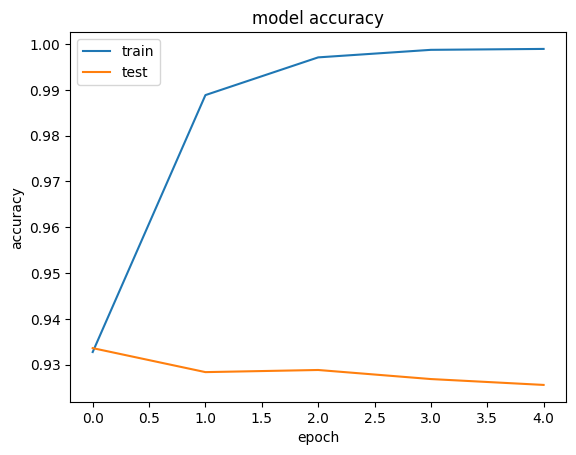

In [ ]:
#plot accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
